## Installing requried packages
* Uncomment if not already installed
* Restart Kernel after

In [1]:
#!/usr/bin/python -m pip install --upgrade pip
#!pip install matplotlib
#!pip install tf-nightly

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib
dataset_url = "https://nrc-digital-repository.canada.ca/eng/view/dataset/?id=ba1fc493-e65f-4c0a-ab31-ecbcdf00bfa4"
data_dir = tf.keras.utils.get_file('NRC-GAMMA-1.0.tgz', origin=dataset_url, extract=False, file_hash="c8bb1ea39559874fd791cebcb99aff456a0570aa9b19908088874ad9aa9899b0")
data_dir = pathlib.Path(data_dir)

In [4]:
# for some reason wehen the origin url doesnt have a full file name like in our case, the automatic download using the extracted directory name doesnt work as expected 
# to work around this we purposely set the path here 
data_dir_str = str(data_dir.parent) + "/NRC-GAMMA-1.0"
data_dir = pathlib.Path(data_dir_str)
print(data_dir)

/home_exp/paulp/.keras/datasets/NRC-GAMMA-1.0


In [5]:
our_data_path=pathlib.Path(str(data_dir)+"/data/cropped")

In [6]:
import os
from shutil import copyfile
#create labeled_dataset
our_ds_path=str(data_dir)+"/work"

if not os.path.exists(our_ds_path):
    os.makedirs(our_ds_path)

num_class=10
    
for i in range(0, num_class):
    if not os.path.exists(our_ds_path+"/"+str(i)):
        os.makedirs(our_ds_path+"/"+str(i))
    our_files = list(our_data_path.glob('*_'+str(i)+'.jpg'))
    print(str(i)+": "+str(len(our_files)))
    for file in our_files:
        if not os.path.exists(our_ds_path+"/"+str(i)+"/"+str(os.path.basename(file))):
            copyfile(file, our_ds_path+"/"+str(i)+"/"+str(os.path.basename(file)))

0: 5983
1: 5195
2: 5714
3: 6368
4: 5710
5: 5801
6: 5086
7: 6818
8: 6424
9: 6326


In [7]:
#load data
batch_size = 32
img_height = 160
img_width = 160

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  our_ds_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 59425 files belonging to 10 classes.
Using 47540 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  our_ds_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 59425 files belonging to 10 classes.
Using 11885 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


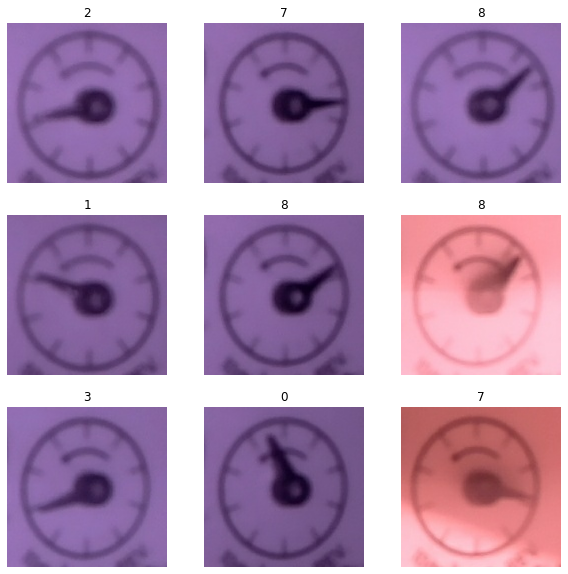

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [12]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.11764707 0.9960785


In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 160, 160, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 80, 80, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 40, 40, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 64)        1

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
1486/1486 [==============================] - 25s 12ms/step - loss: 0.3867 - accuracy: 0.8650 - val_loss: 0.1635 - val_accuracy: 0.9387
Epoch 2/10
1486/1486 [==============================] - 17s 11ms/step - loss: 0.1723 - accuracy: 0.9317 - val_loss: 0.1905 - val_accuracy: 0.9390
Epoch 3/10
1486/1486 [==============================] - 16s 11ms/step - loss: 0.1622 - accuracy: 0.9361 - val_loss: 0.1451 - val_accuracy: 0.9419
Epoch 4/10
1486/1486 [==============================] - 14s 10ms/step - loss: 0.1561 - accuracy: 0.9386 - val_loss: 0.1432 - val_accuracy: 0.9430
Epoch 5/10
1486/1486 [==============================] - 17s 12ms/step - loss: 0.1527 - accuracy: 0.9391 - val_loss: 0.1399 - val_accuracy: 0.9419
Epoch 6/10
1486/1486 [==============================] - 17s 12ms/step - loss: 0.1513 - accuracy: 0.9390 - val_loss: 0.1475 - val_accuracy: 0.9457
Epoch 7/10
1486/1486 [==============================] - 15s 10ms/step - loss: 0.1481 - accuracy: 0.9402 - val_loss: 0.1395 -

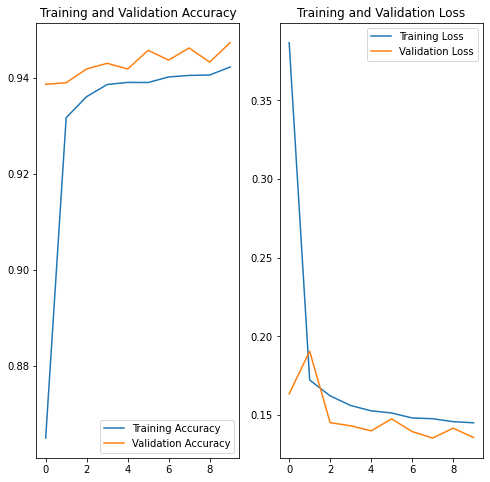

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

/home/paulp/devel/gamma_classifier


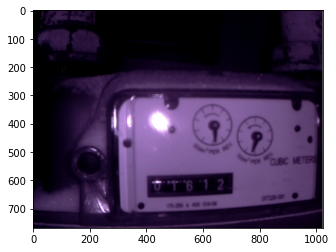

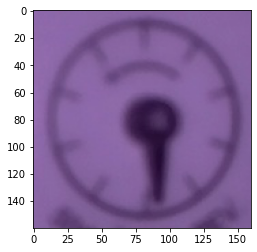

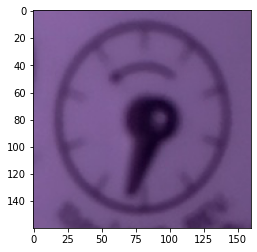

In [47]:
!pwd
#first of 20200119
#unseen_img = "20200119/full/1579411699888.jpg"

#2000th of 20200119
unseen_img = "20200119/full/1579415668631.jpg"

full = tf.keras.utils.load_img(unseen_img)
plt.figure()
plt.imshow(full)

# Setting the points for cropped image
left = 552
top = 325
right = 552+160
bottom = 325+160
 
# Cropped image of above dimension
# (It will not change original image)
left_img = full.crop((left, top, right, bottom))

plt.figure()
plt.imshow(left_img)

left = 703
top = 365
right = 703+160
bottom = 365+160

right_img = full.crop((left, top, right, bottom))

plt.figure()
plt.imshow(right_img)

In [44]:
img_array = tf.keras.utils.img_to_array(left_img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 5 with a 100.00 percent confidence.


In [45]:
img_array = tf.keras.utils.img_to_array(right_img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 4 with a 99.71 percent confidence.
